Using an CNN Autoencoder to cluster column maxes for each track, to cluster together protons + deuterons and noise. 

Data created in **padded_data.ipynb** which uses data created in **clusters_data.ipynb**.

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader 

import numpy as np
import matplotlib.pyplot as plt

In [2]:
PATH_ALL = "/Users/user/data/research/proton-deuteron/csv/padded_max_adc_columns.npy"
PROTONS = '/Users/user/data/research/proton-deuteron/csv/padded_protons.npy'
DEUTERONS = '/Users/user/data/research/proton-deuteron/csv/padded_deuterons.npy'

In [3]:
# threshold: 15 ADC, for making clusters of connected pixels.
# then, max ADC of each wire in cluster is recorded only in a 1D matrix.
# then this array is padded with zeros on either side, with original wire coordinates preserved.
# cut: wire lengths > 10 only, mixed collection, induction, proton, deuteron candidates.
# full data, pre-training/testing split. 
# 1D data, (1x240), 70922 total data points (16097 proton candidates, 54825 deuterons candidates), collection, induction mixed.   

padded_protons = np.load(PROTONS) 
padded_deuterons = np.load(DEUTERONS)

# CNN Autoencoder. 

Uses CNNs as encoder and decoder. 

In [187]:
class CAE(nn.Module):
    def __init__(self, input=240, latent=8):
        super(CAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, 5, stride=2, padding=2), nn.ReLU(),
            nn.Conv1d(32, 64, 5, stride=2, padding=2), nn.ReLU(),
            nn.Conv1d(64, 128, 5, stride=2, padding=2), nn.ReLU()
        )

        self.fc_enc = nn.Linear(128 * (input // 8), latent)

        self.fc_dec = nn.Linear(latent, 128 * (input // 8))

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(128, 64, 5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, 5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 1, 5, stride=2, padding=2, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        z = self.encoder(x).flatten(1)
        z = self.fc_enc(z)
        y = self.fc_dec(z).view(x.size(0), 128, -1)
        y = self.decoder(y).squeeze(1)
        return y

In [188]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [189]:
model = CAE().to(device)
optim  = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.MSELoss()

In [190]:
X = torch.tensor(padded_protons, dtype=torch.float32).to(device)
train_loader = torch.utils.data.DataLoader(X, batch_size=64, shuffle=True)
epochs = 1000

In [ ]:
for epoch in range(epochs):
    model.train()
    for xb in train_loader:
        xb = xb.to(device)
        optim.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, xb)
        loss.backward()
        optim.step()
    print(f"Epoch {epoch+1}: loss = {loss.item():.4f}")

Epoch 1: loss = 366.5822
Epoch 2: loss = 240.6347
Epoch 3: loss = 146.4875
Epoch 4: loss = 227.7124
Epoch 5: loss = 275.9112
Epoch 6: loss = 115.9099
Epoch 7: loss = 200.2513
Epoch 8: loss = 132.7835
Epoch 9: loss = 147.7584
Epoch 10: loss = 138.3971
Epoch 11: loss = 87.6165
Epoch 12: loss = 163.7975
Epoch 13: loss = 82.0796
Epoch 14: loss = 274.0901
Epoch 15: loss = 241.2247


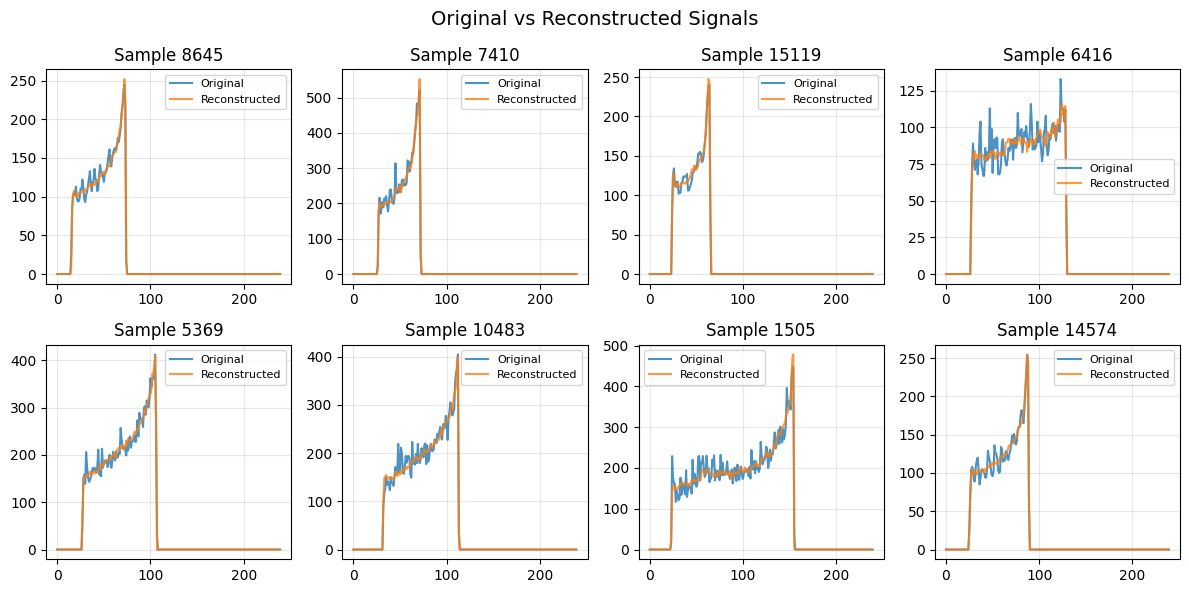

In [31]:
model.eval()

N = 8
X_cpu = X.detach().cpu().numpy()             # full dataset, shape (N_total, 240)
sample_idx = np.random.choice(len(X_cpu), N, replace=False)
X_sample = X[sample_idx].to(device)          # shape (N, 240)

# Run through model
with torch.no_grad():
    recons = model(X_sample).cpu().numpy()   # shape (N, 240)

# Original signals
X_orig = X_sample.cpu().numpy()

# Plot
plt.figure(figsize=(12, 6))
for i in range(N):
    plt.subplot(2, N // 2, i + 1)
    plt.plot(X_orig[i], label='Original', alpha=0.8)
    plt.plot(recons[i], label='Reconstructed', alpha=0.8)
    plt.title(f"Sample {sample_idx[i]}")
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=8)
plt.suptitle("Original vs Reconstructed Signals", fontsize=14)
plt.tight_layout()
plt.show()


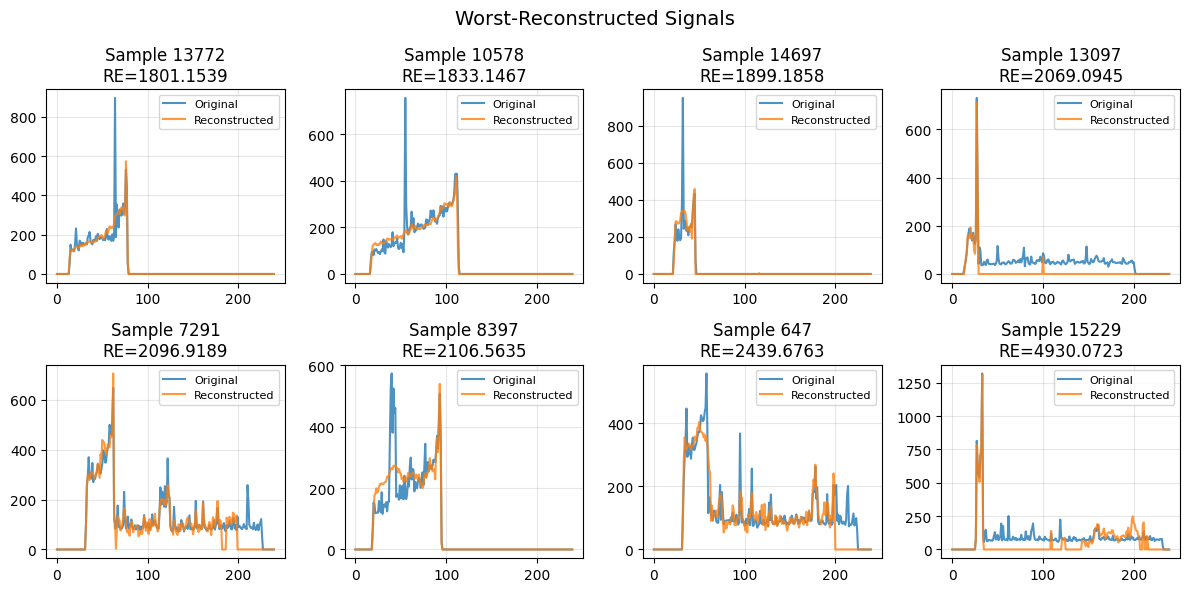

In [33]:
model.eval()

# Compute full reconstruction and REs
with torch.no_grad():
    recon_all = model(X)                  # shape (N, 240)
    re = F.mse_loss(recon_all, X, reduction='none')  # shape (N, 240)
    RE_per_sample = re.mean(dim=1).cpu().numpy()     # shape (N,)

# Sort by highest RE
worst_idx = np.argsort(RE_per_sample)[-8:]  # top 8 worst

# Get originals and recons
X_worst = X[worst_idx].cpu().numpy()
recon_worst = recon_all[worst_idx].cpu().numpy()

# Plot
plt.figure(figsize=(12, 6))
for i in range(len(worst_idx)):
    plt.subplot(2, 4, i + 1)
    plt.plot(X_worst[i], label='Original', alpha=0.8)
    plt.plot(recon_worst[i], label='Reconstructed', alpha=0.8)
    plt.title(f"Sample {worst_idx[i]}\nRE={RE_per_sample[worst_idx[i]]:.4f}")
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=8)
plt.suptitle("Worst-Reconstructed Signals", fontsize=14)
plt.tight_layout()
plt.show()

In [102]:
with torch.no_grad():
    recons = model(X)  # X shape: (N, 240)
    mse = F.mse_loss(recons, X, reduction='none')  # shape (N, 240)
    RE_per_sample = mse.mean(dim=1).cpu().numpy()  # shape (N,)

with torch.no_grad():
    z_all = model.encoder(X.unsqueeze(1))     # (N, 1, 240) → (N, 64, 60)
    z_all = z_all.flatten(1)                  # flatten to (N, 64*60)
    latent_vectors = model.fc_enc(z_all).cpu().numpy()

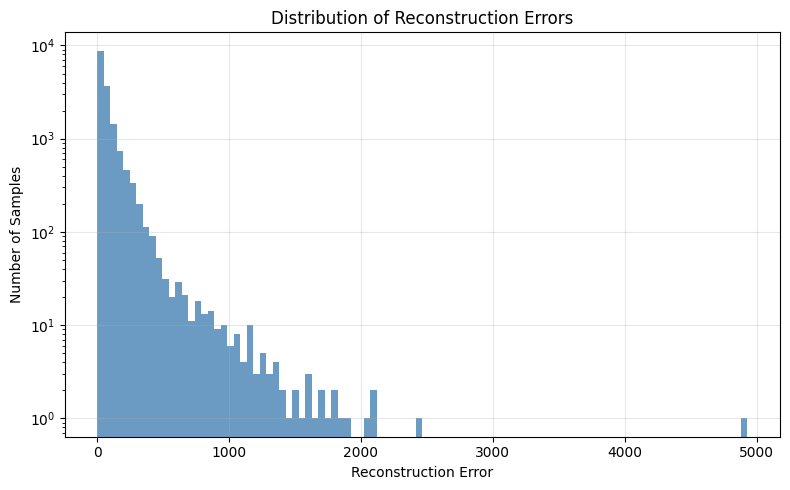

In [103]:
plt.figure(figsize=(8, 5))
plt.hist(RE_per_sample, bins=100, color='steelblue', alpha=0.8)
plt.xlabel("Reconstruction Error")
plt.ylabel("Number of Samples")
plt.title("Distribution of Reconstruction Errors")
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

In [147]:
from sklearn.preprocessing import StandardScaler

# features = np.concatenate([RE_per_sample.reshape(-1, 1), latent_vectors], axis=1)
features = latent_vectors

scaler   = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [149]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=200,     # tune5–20
                            min_samples=None,        # default = min_cluster_size
                            metric='euclidean',
                            cluster_selection_method='eom')
labels = clusterer.fit_predict(X_scaled)             # -1 = noise
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Found {n_clusters} clusters (+ noise)")


/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Found 2 clusters (+ noise)


In [158]:
from sklearn.mixture import BayesianGaussianMixture
bgmm = BayesianGaussianMixture(n_components=4, weight_concentration_prior_type='dirichlet_process')
labels = bgmm.fit_predict(X_scaled)

/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-pac

In [176]:
from sklearn.cluster import SpectralClustering
labels = SpectralClustering(n_clusters=3, affinity='nearest_neighbors').fit_predict(X_scaled)

/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-pac

In [180]:
from sklearn.cluster import AgglomerativeClustering
labels = AgglomerativeClustering(n_clusters=3, linkage='ward').fit_predict(X_scaled)

In [150]:
from sklearn.manifold import TSNE

proj = TSNE(n_components=2, perplexity=90, random_state=0).fit_transform(X_scaled)

/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packag

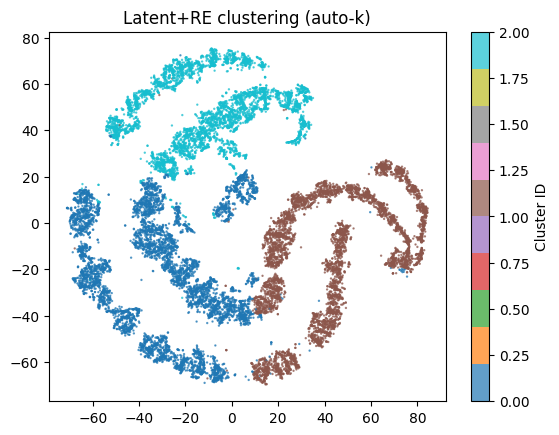

In [181]:
plt.scatter(proj[:, 0], proj[:, 1], c=labels, cmap='tab10', alpha=0.7, s=0.5)
plt.title("Latent+RE clustering (auto-k)")
plt.colorbar(label="Cluster ID")
plt.show()

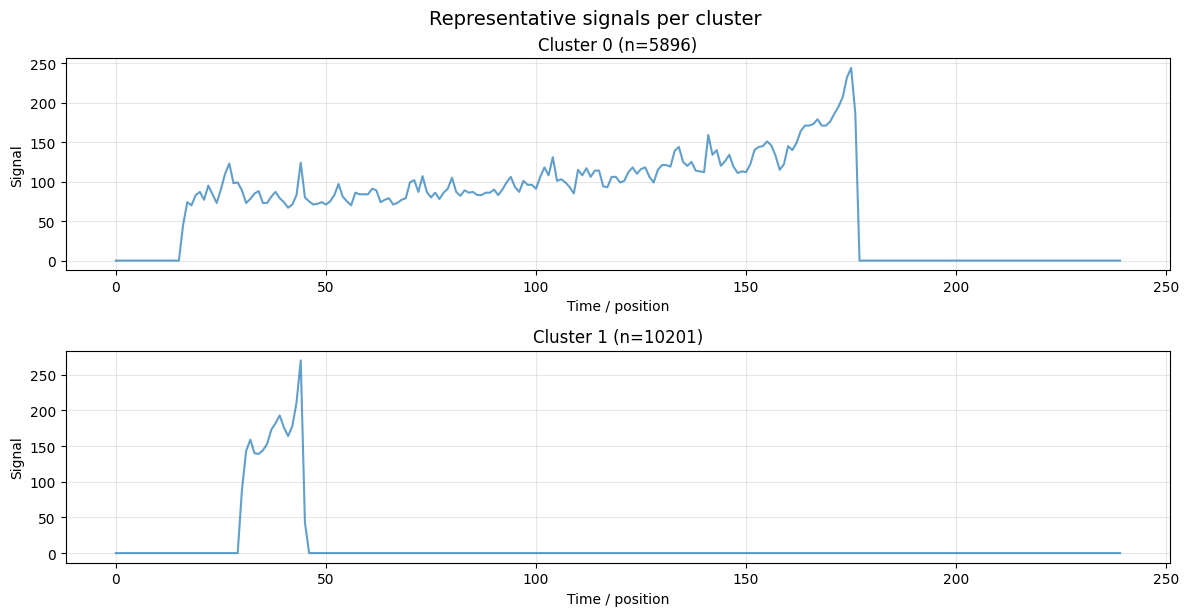

In [175]:
# ── prep data ──────────────────────────────────────────
X_np = X.cpu().numpy()            # original signals, shape (N, 240)
unique_labels = np.unique(labels) # e.g. [-1, 0, 1, 2, …]

# how many examples to show per cluster
n_plot = 1                     # adjust as you like

# set up a subplot row per cluster
n_rows = len(unique_labels)
fig, axes = plt.subplots(n_rows, 1, figsize=(12, 3 * n_rows))

if n_rows == 1:                   # when there’s only one cluster
    axes = [axes]

# ── loop over clusters ─────────────────────────────────
for ax, cid in zip(axes, unique_labels):
    mask   = labels == cid
    count  = mask.sum()
    sample = X_np[mask]

    # pick up to n_plot random examples
    k = min(n_plot, count)
    if k > 0:
        idx = np.random.choice(count, k, replace=False)
        for sig in sample[idx]:
            ax.plot(sig, alpha=0.7)

    title = f"Cluster {cid} (n={count})" if cid != -1 else f"Noise (n={count})"
    ax.set_title(title)
    ax.set_xlabel("Time / position")
    ax.set_ylabel("Signal")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle("Representative signals per cluster", y=1.02, fontsize=14)
plt.show()

In [173]:
import pandas as pd

mean_RE_per_cluster = {
    cid: RE_per_sample[labels == cid].mean()
    for cid in np.unique(labels)
    if cid != -1
}

df = pd.DataFrame.from_dict(mean_RE_per_cluster, orient='index', columns=['Mean RE'])
df = df.sort_values('Mean RE')
print(df)

      Mean RE
1   47.768318
0  144.793839


Testing on deuteron candidates

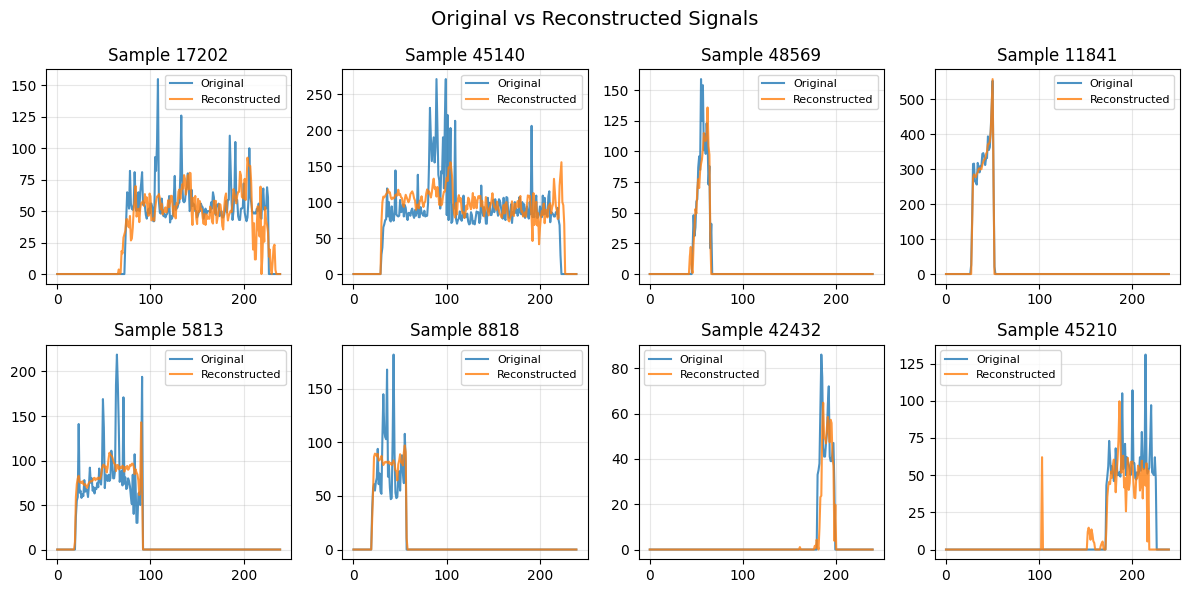

In [84]:
model.eval()

N = 8
X_cpu = Y.detach().cpu().numpy()             # full dataset, shape (N_total, 240)
sample_idx = np.random.choice(len(X_cpu), N, replace=False)
X_sample = Y[sample_idx].to(device)          # shape (N, 240)

# Run through model
with torch.no_grad():
    recons = model(X_sample).cpu().numpy()   # shape (N, 240)

# Original signals
X_orig = X_sample.cpu().numpy()

# Plot
plt.figure(figsize=(12, 6))
for i in range(N):
    plt.subplot(2, N // 2, i + 1)
    plt.plot(X_orig[i], label='Original', alpha=0.8)
    plt.plot(recons[i], label='Reconstructed', alpha=0.8)
    plt.title(f"Sample {sample_idx[i]}")
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=8)
plt.suptitle("Original vs Reconstructed Signals", fontsize=14)
plt.tight_layout()
plt.show()


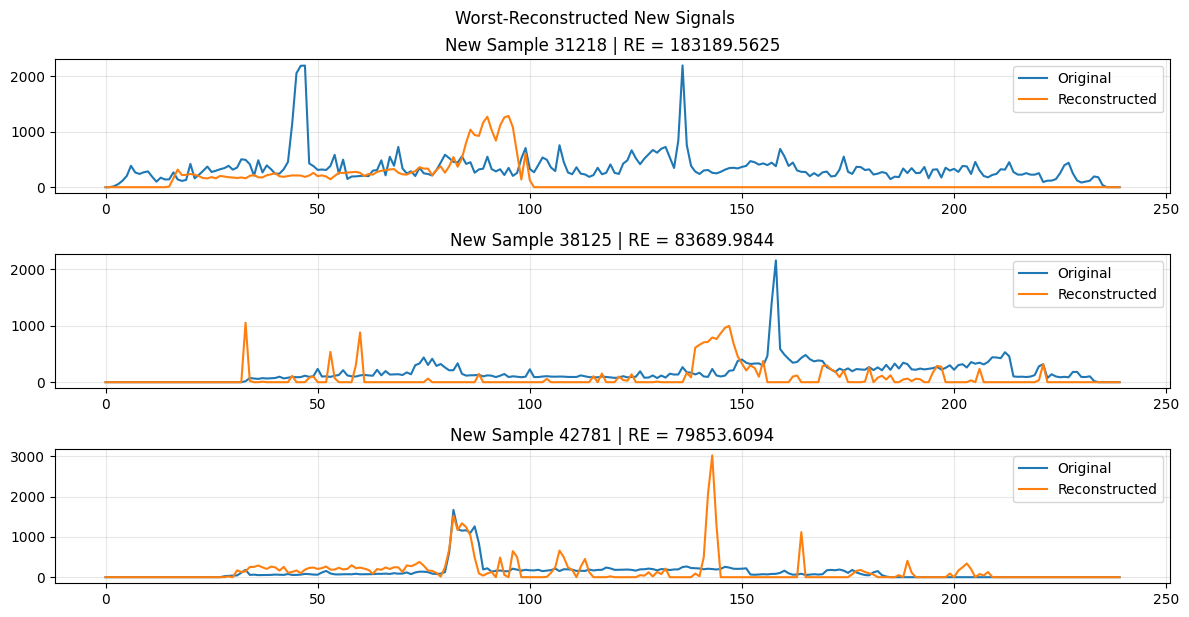

In [35]:
Y = torch.tensor(padded_deuterons, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    recons_new = model(Y)

re = F.mse_loss(recons_new, Y, reduction='none')  # (N, 240)
RE_per_sample = re.mean(dim=1).cpu().numpy()  # shape (N,)

top_n = 3
worst_indices = np.argsort(-RE_per_sample)[:top_n]

plt.figure(figsize=(12, 2 * top_n))
for i, idx in enumerate(worst_indices):
    plt.subplot(top_n, 1, i + 1)
    plt.plot(Y[idx].squeeze().cpu().numpy(), label='Original')
    plt.plot(recons_new[idx].squeeze().cpu().numpy(), label='Reconstructed')
    plt.title(f"New Sample {idx} | RE = {RE_per_sample[idx]:.4f}")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle("Worst-Reconstructed New Signals", y=1.02)
plt.show()

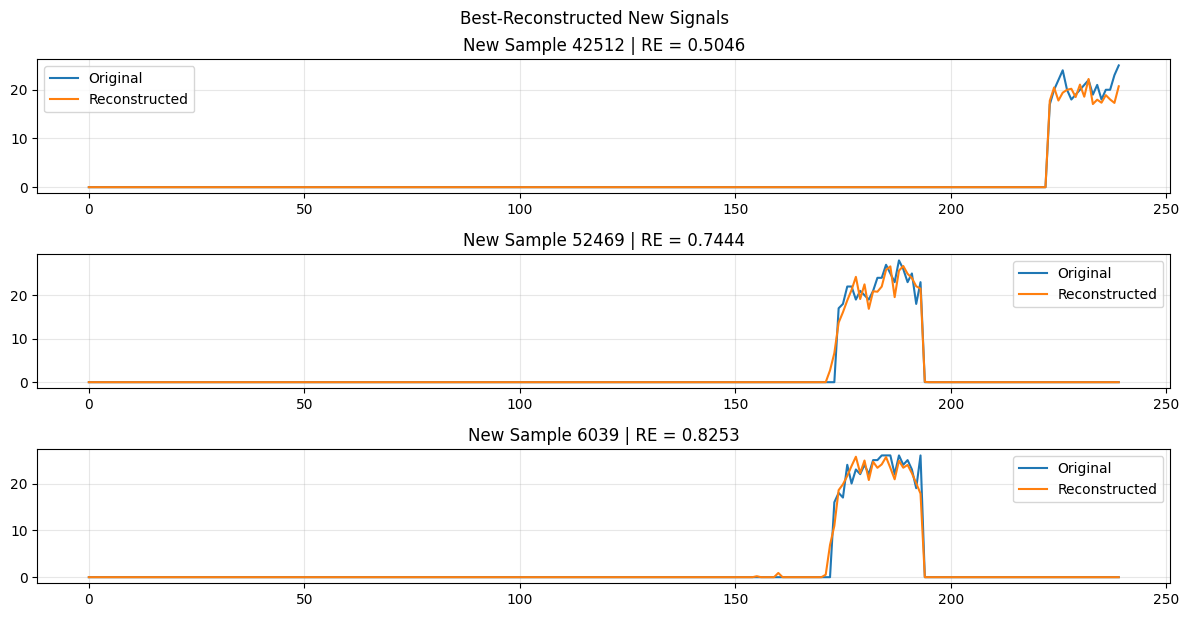

In [37]:
# Get indices of best-reconstructed samples (lowest RE)
best_n = 3
best_indices = np.argsort(RE_per_sample)[:best_n]  # ascending order

# Plot
plt.figure(figsize=(12, 2 * best_n))
for i, idx in enumerate(best_indices):
    plt.subplot(best_n, 1, i + 1)
    plt.plot(Y[idx].squeeze().cpu().numpy(), label='Original')
    plt.plot(recons_new[idx].squeeze().cpu().numpy(), label='Reconstructed')
    plt.title(f"New Sample {idx} | RE = {RE_per_sample[idx]:.4f}")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle("Best-Reconstructed New Signals", y=1.02)
plt.show()

In [ ]:
with torch.no_grad():
    recons = model(Y)  # X shape: (N, 240)
    mse = F.mse_loss(recons, Y, reduction='none')  # shape (N, 240)
    RE_per_sample = mse.mean(dim=1).cpu().numpy()  # shape (N,)

with torch.no_grad():
    z_all = model.encoder(Y.unsqueeze(1))     # (N, 1, 240) → (N, 64, 60)
    z_all = z_all.flatten(1)                  # flatten to (N, 64*60)
    latent_vectors = model.fc_enc(z_all)      # (N, latent_dim)

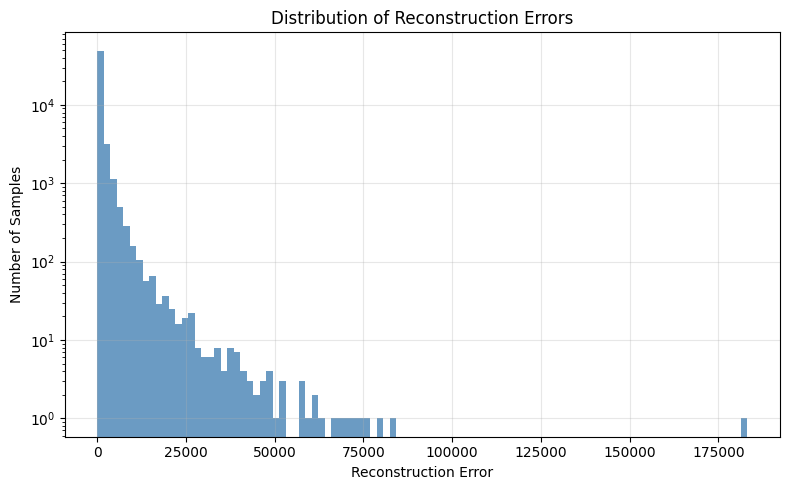

In [40]:
plt.figure(figsize=(8, 5))
plt.hist(RE_per_sample, bins=100, color='steelblue', alpha=0.8)
plt.xlabel("Reconstruction Error")
plt.ylabel("Number of Samples")
plt.title("Distribution of Reconstruction Errors")
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

In [52]:
from sklearn.preprocessing import StandardScaler

features = np.concatenate([RE_per_sample.reshape(-1, 1), latent_vectors.cpu()], axis=1)

scaler   = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [87]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=2000,     # tune 5–20
                            min_samples=500,        # default = min_cluster_size
                            metric='euclidean',
                            cluster_selection_method='eom')
labels = clusterer.fit_predict(X_scaled)             # -1 = noise
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Found {n_clusters} clusters (+ noise)")


/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Found 2 clusters (+ noise)


In [88]:
from sklearn.manifold import TSNE

proj = TSNE(n_components=2, perplexity=30, random_state=0).fit_transform(X_scaled)


/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packag

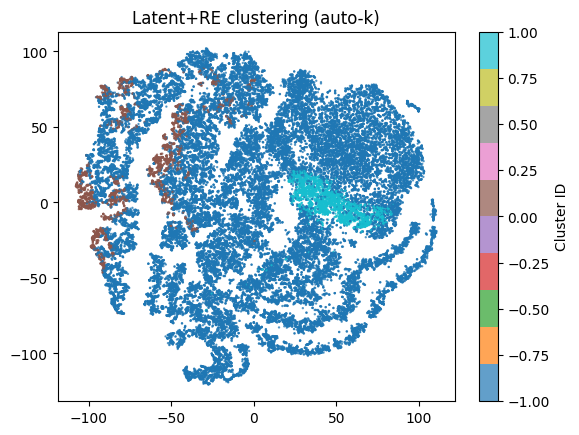

In [89]:
plt.scatter(proj[:, 0], proj[:, 1], c=labels, cmap='tab10', alpha=0.7, s=0.5)
plt.title("Latent+RE clustering (auto-k)")
plt.colorbar(label="Cluster ID")
plt.show()

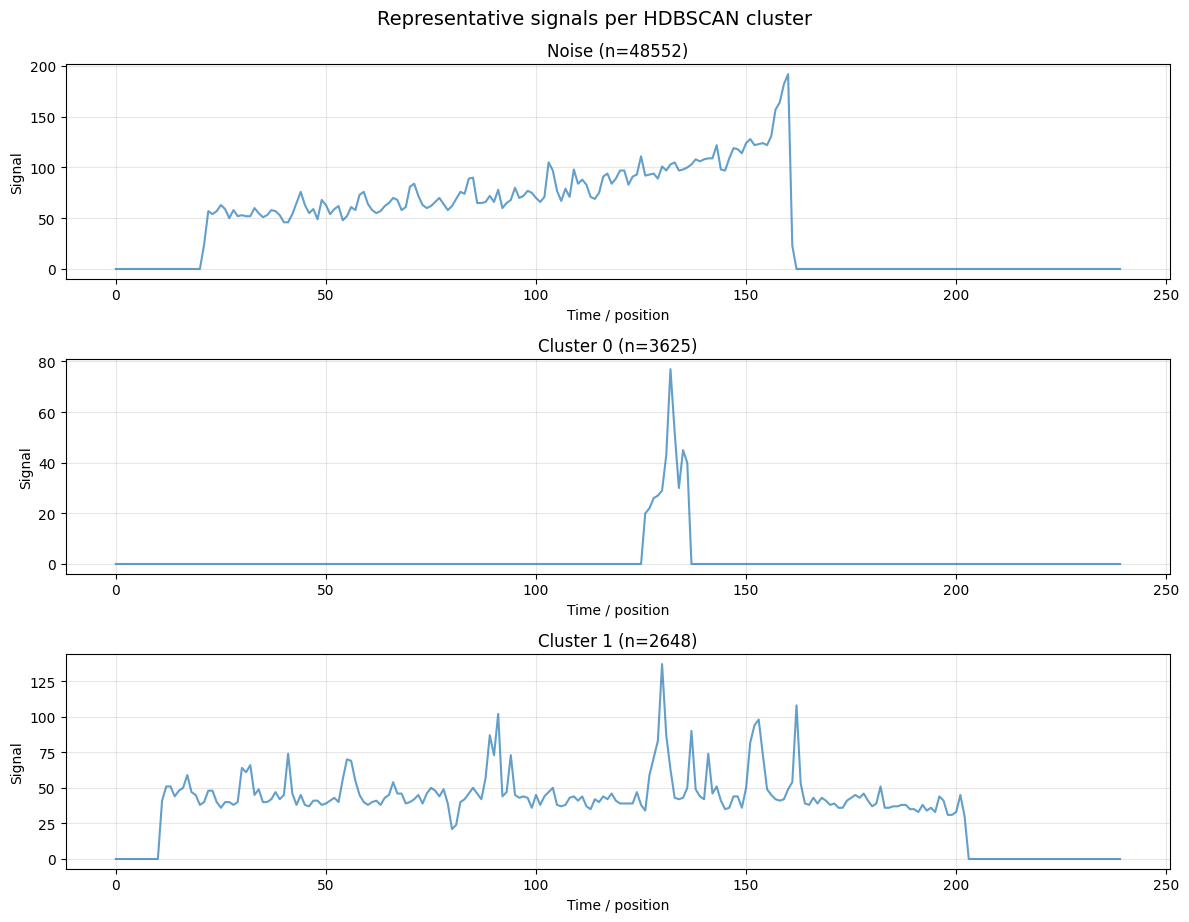

In [96]:
# ── prep data ──────────────────────────────────────────
X_np = Y.cpu().numpy()            # original signals, shape (N, 240)
unique_labels = np.unique(labels) # e.g. [-1, 0, 1, 2, …]

# how many examples to show per cluster
n_plot = 1                     # adjust as you like

# set up a subplot row per cluster
n_rows = len(unique_labels)
fig, axes = plt.subplots(n_rows, 1, figsize=(12, 3 * n_rows))

if n_rows == 1:                   # when there’s only one cluster
    axes = [axes]

# ── loop over clusters ─────────────────────────────────
for ax, cid in zip(axes, unique_labels):
    mask   = labels == cid
    count  = mask.sum()
    sample = X_np[mask]

    # pick up to n_plot random examples
    k = min(n_plot, count)
    if k > 0:
        idx = np.random.choice(count, k, replace=False)
        for sig in sample[idx]:
            ax.plot(sig, alpha=0.7)

    title = f"Cluster {cid} (n={count})" if cid != -1 else f"Noise (n={count})"
    ax.set_title(title)
    ax.set_xlabel("Time / position")
    ax.set_ylabel("Signal")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle("Representative signals per HDBSCAN cluster", y=1.02, fontsize=14)
plt.show()
